## Illustration: simple death model

In this notebook we provide an example which finds the optimal design for the simple death model using stochastic gradient descent (SGD).

#### Data Model

Consider the simple death model with a single observation time, $\tau$. In this scenario the observation model is $Y \sim Bin(n, \lambda)$ where $\lambda = e^{-\theta \tau}$. Here $n$ is a known constant and $\theta$ is the parameter of interest.

Following the example of previous work, we take a $LN(−0.005, 0.01)$ prior distribution for $\theta$ and $n=50$.

#### Utility Function

In this illustration we use the fisher information gain (FIG) as the chosen utility function. This quantifies how much is leaned about the parameter of interest at a given design time.

For the death model the FIG is given by

$$
I_\theta(\theta) =
\frac{n \tau^2 \lambda}{1-\lambda} =
\frac{n \tau^2 e^{-\theta\tau}}{1-e^{-\theta\tau}},
$$

and utility

$$
U_{FIG}(\tau) = \mathbb{E}_\theta[ I_\theta(\theta) ].
$$

To estimate the expectation over $\theta$, a Monte Carlo estimate is used.

#### Using SGD to target the optimal design

Here we use the Tensorflow module to implement a SGD algorithm on the loss function (negated utility function) searching over the design space. Any SGD method can be applied; here we use the adaptive moment estimation (Adam).

#### 1d utility surface

<figure>
  <img src="simple_death_1d.png" alt="Drawing"/>
  <figcaption>Plot of the utility surface with the optimal design indicated.</figcaption>
</figure>

## Implementation using Tensorflow

First import the dependencies.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Define the constants. Here we randomly generate the initial state uniformly over the search space $[0,10]$.

In [3]:
n = 50. #this is the initial population size, i.e. population at time 0

initial_design = np.random.uniform(low=0., high=10., size=[]) #sample an initial state

Next we define the model and FIG using Tensorflow. Note that we are using a descent algorithm rather than an ascent algorithm hence by default this will minimise the objective function. Thus the loss function, defined the negated utility function, is used as the objective function here.

In [4]:
# use the sampled initial_design as the value to initialise the design at
design = tf.Variable(tf.constant(initial_design, dtype=tf.float32))
# sample theta from a log-Normal distribution
theta = tf.exp(tf.random_normal([], mean=-0.005, stddev=np.sqrt(0.01)))
# calculate lambda
prob = tf.exp(-1. * theta * design)
# compute FIG
fig = tf.pow(design, 2.) * n * prob / (1 - prob)
# compute the loss function (-FIG), based on only 1 estimate being used in MC estimate
loss = -tf.reduce_mean(fig)

Next, we define the optimiser and initialise the global variables.

In [5]:
optimiser = tf.train.AdamOptimizer()
train = optimiser.minimize(loss)
init = tf.global_variables_initializer()

We can now run the stochastic optimisation for a set number of iterations. Here we will use $5 \times 10^4$ iterations.

In [6]:
# split the iterations into blocks so that it is easy to include a convergence criterion
# also reduces memory required if lots of iterations are required
nloops = 500
its_per_loop = 100

iterations = np.zeros(nloops)
designs = np.zeros(nloops)
losses = np.zeros(nloops)
with tf.Session() as sess:
    sess.run(init)
    for i in range(nloops):
        mean_loss = 0.
        for j in range(its_per_loop):
            next_loss, next_design, _ = sess.run([loss, design, train])
            mean_loss += next_loss
        mean_loss /= its_per_loop
        print("Current loop: {:3d}  Current utility: {:.3f}".format(i, -1.* mean_loss), end="\r")
        iterations[i] = i*its_per_loop
        designs[i] = next_design
        losses[i] = mean_loss
        mean_loss = 0.

Now we can make plots of the output.

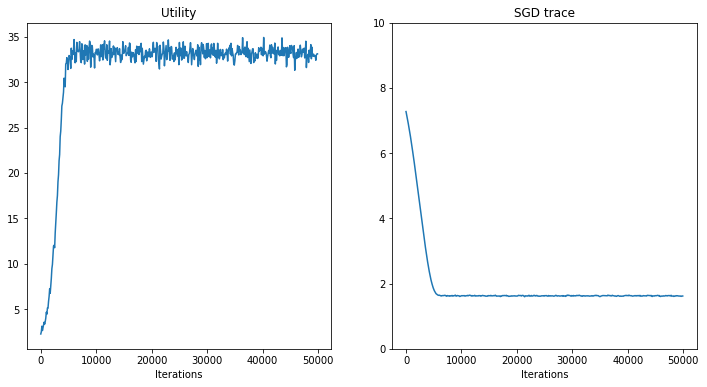

In [7]:
fig = plt.figure()
fig.set_size_inches(12,6)

# plot the trace of the utility
plt.subplot(1,2,1)
plt.plot(iterations,-losses); plt.title('Utility') # utility = -1 * loss
plt.xlabel('Iterations')

# plot the trace of the design
plt.subplot(1,2,2)
plt.plot(iterations, designs)
plt.ylim(0,10)
plt.title('SGD trace')
plt.xlabel('Iterations')

plt.show()